In [1]:
import matplotlib.pyplot as plt
import arviz as az
import numpy as np
import pymc

import os, sys
sys.path.append(os.path.join("../../"))

import privugger as pv


# Governor case study

In this tutorial, we explore the famous case study presented by [Sweeny 2002](https://dl.acm.org/doi/10.1142/S0218488502001648) where she re-identified the the medical records of the governor of Masachussets. The problem the dataset was that records were "anonymized" simply by removing identifiers. Nowadays, it is well known that this is a naïve and insufficient method for anonymization data. Yet many real applications still use this type of "anonymization". 

This tutorial shows how privugger can be used analyze the uniqueness of records after identifiers have been removed.

## Naïve anonymization program (removing identifiers)

We consider a program that takes a dataset with attributes: `name`, `zip`, `age`, `gender` and `diagnosis`. In this dataset, `name` is considered an identifier (this is an unrealistic assumption, since in reality there can be many people with the same name, but it serves the purpose of the tutorial). 

As you can see below, the program simply returns a dataset without names.

In [2]:
def remove_names(names, zips, ages, genders, diagnoses):
    output = []
    output.append(zips)
    output.append(ages)
    output.append(genders)
    output.append(diagnoses)
    return np.array(output, dtype=object)

## Input specification

Note that this specification is _compositional_, we define different parts of the dataset and concatenate them as the bottom.

We consider a dataset with 100 records. At this point, we fix the attributes of the victim's record (from now on called Alice). Alice is 25 years old, lives in ZIP code 50 (this is just a nominal placeholder for a real zip code), she is female and she is ill. These values are defined as constants of the form `ALICE_XXX` below.

We define a constant record (using point distributions) that we may add to the specification to ensure that Alice's record is in the dataset. This step is optional. In fact, when the analysis is performed without this record, we model an adversary who doesn't know whether Alice is in the dataset.

The variables `xxx_others` contain the spec for the records in the dataset. We have 5 different names uniformly distributed, ages are normally distributed with the most likely age being around 55. We consider 100 different ZIP codes uniformly distributed. Two genders (though acknowledging that this is a simplification and more genders exist) which are uniformly distributed. As for the diagnosis, there is a 20% chance of being ill.

The following lines show how to merge Alice's record with the rest of the dataset. This also exemplifies how to compositionally define input specifications.

Finally, we create the `Dataset` object with the complete input spec.

In [3]:
N = 100

# Victim's record

## Constant values for Alice's record
ALICE_NAME      = np.int64(0)
ALICE_AGE       = np.float64(25)
ALICE_ZIP       = np.int64(50)
ALICE_GENDER    = np.int64(1)
ALICE_DIAGNOSIS = np.int64(1)

## Spec for Alice's record (all point distributions with the values above)
alice_name      = pv.Constant("alice_name",ALICE_NAME, num_elements=1)
alice_age       = pv.Normal("alice_age", mu=ALICE_AGE, std=0.01, num_elements=1)
alice_zip       = pv.Constant("alice_zip",ALICE_ZIP, num_elements=1)
alice_gender    = pv.Constant("alice_gender",ALICE_GENDER, num_elements=1) # 1: female, 0: male
alice_diagnosis = pv.Constant("alice_diagnosis", ALICE_DIAGNOSIS, num_elements=1) # 0: healthy, 1: ill

# Spec for the records of others    
names_others     = pv.DiscreteUniform("names_others", 0, 5, num_elements=N)
ages_others      = pv.Normal("ages_others", mu=55.2, std=3.5, num_elements=N)
zips_others      = pv.DiscreteUniform("zips_others", 0, 100, num_elements=N)
genders_others   = pv.Bernoulli("genders_others",p=.5,num_elements=N) 
diagnoses_others = pv.Bernoulli("diagnoses_others", p=.2,num_elements=N)

# Merging all in a single dataset spec
names     = pv.concatenate((names_others, alice_name),  "discrete")
zips      = pv.concatenate((zips_others, alice_zip), "discrete")
ages      = pv.concatenate((ages_others, alice_age),  "continuous")
genders   = pv.concatenate((genders_others, alice_gender), "discrete")
diagnoses = pv.concatenate((diagnoses_others, alice_diagnosis), "discrete")

# Dataset spec
ds = pv.Dataset(input_specs = [names, zips, ages, genders, diagnoses])

## Program specification

The program specification takes the input specification above, and the program to analyze `remove_names`. We give the name `'output'` to the distribution of the output of the program. In this example, it is important to remark that the output of the program is a matrix of floats (i.e., a numeric dataset). In this matrix, each row models a row in the dataset, and each column models an attribute.

In [4]:
program   = pv.Program('output', dataset=ds, output_type=pv.Matrix(pv.Float), function=remove_names)

## Inference

We use the pymc3 backend to perform the inference.

In [5]:
trace = pv.infer(program, cores=4, draws=10000, method='pymc3', return_model=False)

Multiprocess sampling (2 chains in 4 jobs)
CompoundStep
>CompoundStep
>>Metropolis: [names_others]
>>Metropolis: [alice_name]
>>Metropolis: [zips_others]
>>Metropolis: [alice_zip]
>>Metropolis: [alice_gender]
>>Metropolis: [alice_diagnosis]
>NUTS: [ages_others, alice_age]
>BinaryGibbsMetropolis: [genders_others, diagnoses_others]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 118 seconds.


## Privacy Risk Analysis

In this tutorial, we focus on uniqueness queries. That is, we quantify how unique Alice's record is based on her attribute values.

### How many records share the Alice's attribute values?

First we compute the average of the number of records that have the same values as Alice's record.

Currentely, privugger does not have built-in functions to compute these type of query so the information in the trace directly.

In [12]:
trace_attr   = lambda attr : np.concatenate([trace.posterior['output'][i][:,attr,:] for i in [0,1]])
age_row = 0

names_db     = np.concatenate([trace.posterior['names_others'].values[i] for i in [0,1]])
zips_db      = trace_attr(0)
ages_db      = trace_attr(1)
genders_db   = trace_attr(2)
diagnoses_db = trace_attr(3)


print("Avg. number of rows with gov's name: ",sum([np.count_nonzero(names_db[i]==ALICE_NAME) for i in range(0,len(names_db))])/len(names_db))
print("Avg. number of rows with gov's zip: ",sum([np.count_nonzero(zips_db[i]==ALICE_ZIP) for i in range(0,len(zips_db))])/len(zips_db))
print("Avg. number of rows with gov's age: ",sum([np.count_nonzero(ages_db[i]<=ALICE_AGE+0.1) for i in range(0,len(zips_db))])/len(zips_db)) # 1.0 is expected
print("Avg. number of rows with gov's gender: ",sum([np.count_nonzero(genders_db[i]==ALICE_GENDER) for i in range(0,len(genders_db))])/len(genders_db))
print("Avg. number of rows with gov's diagnosis: ",sum([np.count_nonzero(diagnoses_db[i]==ALICE_DIAGNOSIS) for i in range(0,len(diagnoses_db))])/len(diagnoses_db))

Avg. number of rows with gov's name:  16.6229
Avg. number of rows with gov's zip:  1.989
Avg. number of rows with gov's age:  1.0
Avg. number of rows with gov's gender:  50.9747
Avg. number of rows with gov's diagnosis:  20.96925


### Attributed based uniqueness histograms

A more interesting perspective is to plot histograms showing the probability of having $n$ records equal to Alice's attributes.

Here we focus on the attributes `gender` and `zip`. The plots below show the probability of having $n \in \mathbb{N}$ number of records with: 1) the same gender as Alice, 2) the same zip code as Alice, 3) the same gender _and_ zip code as Alice.

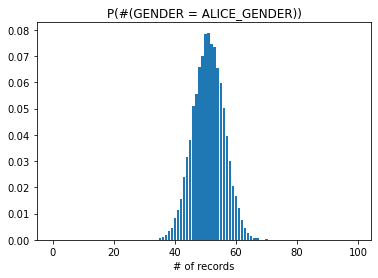

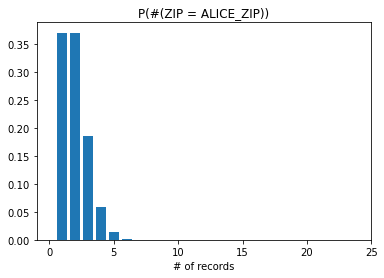

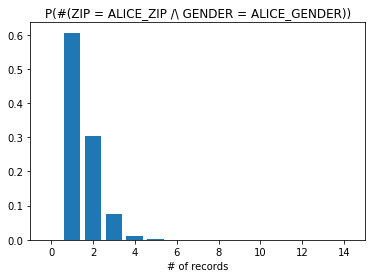

In [13]:
total_samples=len(genders_db)
total_N=N

count_gov_genders=np.array([np.count_nonzero(
    (genders_db[i]==ALICE_GENDER)
) for i in range(0,total_samples)])

count_gov_zips=np.array([np.count_nonzero(
    (zips_db[i]==ALICE_ZIP)
) for i in range(0,total_samples)])

count_gov_genders_zips=np.array([np.count_nonzero(
    (zips_db[i]==ALICE_ZIP) &
    (genders_db[i]==ALICE_GENDER)
) for i in range(0,total_samples)])


y1=[np.count_nonzero(count_gov_genders==i)/len(count_gov_genders) for i in range(0,total_N)]
y2=[np.count_nonzero(count_gov_zips==i)/len(count_gov_zips) for i in range(0,total_N)]
y3=[np.count_nonzero(count_gov_genders_zips==i)/len(count_gov_genders_zips) for i in range(0,total_N)]
plt.bar(range(0,total_N),y1)
plt.title("P(#(GENDER = ALICE_GENDER))")
plt.xlabel("# of records")
plt.show()
plt.bar(range(0,total_N),y2)
plt.title("P(#(ZIP = ALICE_ZIP))")
plt.xlim((-1,25))
plt.xlabel("# of records")
plt.show()
plt.bar(range(0,total_N),y3)
plt.title("P(#(ZIP = ALICE_ZIP /\ GENDER = ALICE_GENDER))")
plt.xlim((-1,15))
plt.xlabel("# of records")
plt.show()


#### Discussion of results

The results show that gender or zip code in isolation have a low probability of uniquely identifying Alice in the dataset. However for both of them combined we observe that the probability of having only one record with those attribute values is close to 60%. This level of risk may be unacceptable for some types of sensitive data.